In [88]:
%load_ext autoreload
%autoreload 2
# ! pip install matplotlib==3.6.2
# ! pip install proplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import tqdm.autonotebook as tqdm
from astropy.io import fits
import pandas as pd
import numpy as np
import proplot as pro
from pathlib import Path
# from vampires_dpp.organization import header_table
from astropy.stats import sigma_clipped_stats
from IPython.core.debugger import set_trace

In [90]:
rootdir = Path("/home/rebeccaz/Github/vampires_calibration/")
datadir = rootdir
figdir = rootdir / "figures"
figdir.mkdir(exist_ok=True)

## Preparing Data



In [91]:
outfile = datadir / "20230914_processed_table.csv"
if outfile.exists():
    table = pd.read_csv(outfile, index_col=0)

### If running from scratch

In [92]:
# columns = ["path", "D_IMRANG", "FILTER01", "OBS-MOD", "RET-POS1", "U_FLC", "GAIN", "EXPTIME"]
# table = header_table(list(datadir.glob("diff/*.fits")))[columns]

# table["D_IMRANG"] = np.round(table["D_IMRANG"] // 0.5) * 0.5
# table.loc[table["D_IMRANG"] == 107, "D_IMRANG"] = 107.5
# table.loc[table["D_IMRANG"] == 119.5, "D_IMRANG"] = 120
# table.loc[table["D_IMRANG"] == 56.5, "D_IMRANG"] = 57.5

In [93]:
# diffs = []
# diff_stds = []
# summs = []
# summ_stds = []
# for idx in tqdm.tqdm(table.index):
#     data = fits.getdata(table.loc[idx, "path"])

#     if data.ndim == 3:
#         diff_mean, diff_median, diff_std = sigma_clipped_stats(data[0], mask=np.isnan(data[0]), sigma=5)
#         summ_mean, summ_median, summ_std = sigma_clipped_stats(data[1], mask=np.isnan(data[1]), sigma=5)
#     elif data.ndim == 4:
#         diff_mean, diff_median, diff_std = sigma_clipped_stats(data[0], mask=np.isnan(data[0]), sigma=5, axis=(-2, -1))
#         summ_mean, summ_median, summ_std = sigma_clipped_stats(data[1], mask=np.isnan(data[1]), sigma=5, axis=(-2, -1))
#     diffs.append(diff_median)
#     diff_stds.append(diff_std)
#     summs.append(summ_median)
#     summ_stds.append(summ_std)
# table["diff"] = diffs
# table["diff_std"] = diff_stds
# table["sum"] = summs
# table["sum_std"] = summ_stds

# table.sort_values(["RET-POS1", "D_IMRANG", "U_FLC"], inplace=True)
# table.to_csv(outfile)

In [94]:
mbi_mask = table["OBS-MOD"].str.endswith('MBI')
filt_groups = table.loc[~mbi_mask].groupby("FILTER01")
mbi_table = table.loc[mbi_mask]

def parse_array_string(x):
    try:
        return np.array([float(i) for i in x.strip("[]").split()])
    except Exception:
        return np.full(4, np.nan)  # Or however many wavelengths you expect


for col in ["diff", "sum"]:
    mbi_table[col] = mbi_table[col].apply(parse_array_string)

/tmp/ipykernel_3968326/194323324.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mbi_table[col] = mbi_table[col].apply(parse_array_string)


## Library functions

In [95]:
mbi_filts = ["F760", "F720", "F670", "F610"]
def plot_single_diff(filt):
    fig, axes = pro.subplots(ncols=2, refwidth="4in", refheight="3in", sharex=0)
    [ax.axhline(0, c="0.6") for ax in axes]
    if filt in mbi_filts:
        subtable = mbi_table
    else:
        subtable = filt_groups.get_group(filt)
    imrangs = subtable["D_IMRANG"].unique()
    cycle = pro.Cycle("magma", len(imrangs), left=0.2, right=0.85)
    colors = {ang: c["color"] for ang, c in zip(imrangs, cycle)}
    for key, group in subtable.groupby(["U_FLC", "D_IMRANG"]):
        if key[0] == "A":
            idx = 0
            label = f"{key[1]:.01f}"
        else:
            idx = 1
            label = None

        if filt in mbi_filts:
            ix = mbi_filts.index(filt)
            norm_diff = [r["diff"][ix] / r["sum"][ix] for _,r in group.iterrows()]
        else:
            norm_diff = (group["diff"] / group["sum"]).values

        color = colors[key[1]]
        axes[idx].plot(
            group["RET-POS1"].values,
            norm_diff,
            label=label,
            c=color,
            m="o",
        )
        axes[idx].format(title=f"FLC: {key[0]}")
    fig.legend(ncols=8, loc="bottom", title="IMR angle (°)")
    fig.suptitle(f"2023/09/14 VAMPIRES {filt}")
    axes.format(
        xlabel="HWP angle (°)",
        ylabel="Normalized difference",
        xlim=(-10, 180),
        ylim=(-1, 1)
    )
    fig.savefig(figdir / f"20230914_{filt}_single_diff.pdf")
    fig.savefig(figdir / f"20230914_{filt}_single_diff.png")
    return fig

In [96]:
def plot_double_diff(filt):
    fig, axes = pro.subplots(refwidth="4in", refheight="3in", sharex=0)
    [ax.axhline(0, c="0.6") for ax in axes]
    if filt in mbi_filts:
        subtable = mbi_table
    else:
        subtable = filt_groups.get_group(filt)
    imrangs = subtable["D_IMRANG"].unique()
    cycle = pro.Cycle("magma", len(imrangs), left=0.2, right=0.85)
    colors = {ang: c["color"] for ang, c in zip(imrangs, cycle)}
    for key, group in subtable.groupby("D_IMRANG"):
        label = f"{key:.01f}"

        if filt in mbi_filts:
            ix = mbi_filts.index(filt)
            flc_groups = group.groupby("U_FLC")
            dbl_diff = flc_groups.get_group("A")["diff"].values - flc_groups.get_group("B")["diff"].values
            dbl_sum = flc_groups.get_group("A")["sum"].values + flc_groups.get_group("B")["sum"].values
            norm_diff = [d[ix] / s[ix] for d, s in zip(dbl_diff, dbl_sum)]
            if filt == "F670" and key == 70:
                print("FLC group A:" + str(flc_groups.get_group("A")["diff"].values))
                print("FLC group B:" + str(flc_groups.get_group("B")["diff"].values))
                print("dbl_diff:", str(dbl_diff))
                print("dbl_sum:", str(dbl_sum))
                print("norm_diff:", str(norm_diff))
        else:
            flc_groups = group.groupby("U_FLC")
            dbl_diff = flc_groups.get_group("A")["diff"].values - flc_groups.get_group("B")["diff"].values
            dbl_sum = flc_groups.get_group("A")["sum"].values + flc_groups.get_group("B")["sum"].values
            norm_diff = dbl_diff / dbl_sum

        color = colors[key]
        axes[0].plot(
            group["RET-POS1"].unique(),
            norm_diff,
            label=label,
            c=color,
            m="o",
        )
    axes[0].format(title="Double difference")
    fig.legend(ncols=4, loc="bottom", title="IMR angle (°)")
    fig.suptitle(f"2023/09/14 VAMPIRES {filt}")
    axes.format(
        xlabel="HWP angle (°)",
        ylabel="Normalized difference",
        xlim=(-10, 180),
        ylim=(-1, 1)
    )
    fig.savefig(figdir / f"20230914_{filt}_double_diff.pdf")
    fig.savefig(figdir / f"20230914_{filt}_double_diff.png")
    return fig

## Multiband

FLC group A:[array([ -1825.5, -10662.5,  -6623.5,  -1611.5])
 array([12334.5,  9551. ,  2201. ,   525. ])
 array([20285. , 22278. ,  9101. ,  2284.5])
 array([18328. , 21281. , 10531. ,  2645.5])
 array([6934.5, 6905. , 6057.5, 1337.5])
 array([ -7140.5, -12786. ,  -2158. ,   -596.5])
 array([-15032.5, -25326. ,  -8956. ,  -2301. ])
 array([-12947.5, -24463.5, -10465. ,  -2712. ])
 array([ -1841. , -10537. ,  -6423. ,  -1553.5])
 array([12138. ,  8368. ,   971. ,   203.5])
 array([19975. , 20022. ,  6808. ,  1511.5])
 array([17747.5, 18193. ,  7405. ,  1600. ])
 array([6274.5, 3228.5, 2263. ,  362. ])
 array([ -7767.5, -16267. ,  -5746.5,  -1583.5])
 array([-15515.5, -27802. , -11579. ,  -3166. ])
 array([-13225. , -25809.5, -12085. ,  -3217. ])]
FLC group B:[array([ 110. , 3473. , 2486. ,  435.5])
 array([-14414. , -17167.5,  -6372.5,  -1633. ])
 array([-22433., -28827., -12201.,  -3141.])
 array([-20003. , -26048. , -12204.5,  -3122. ])
 array([ -8286.5, -10089. ,  -6625. ,  -1673. ]

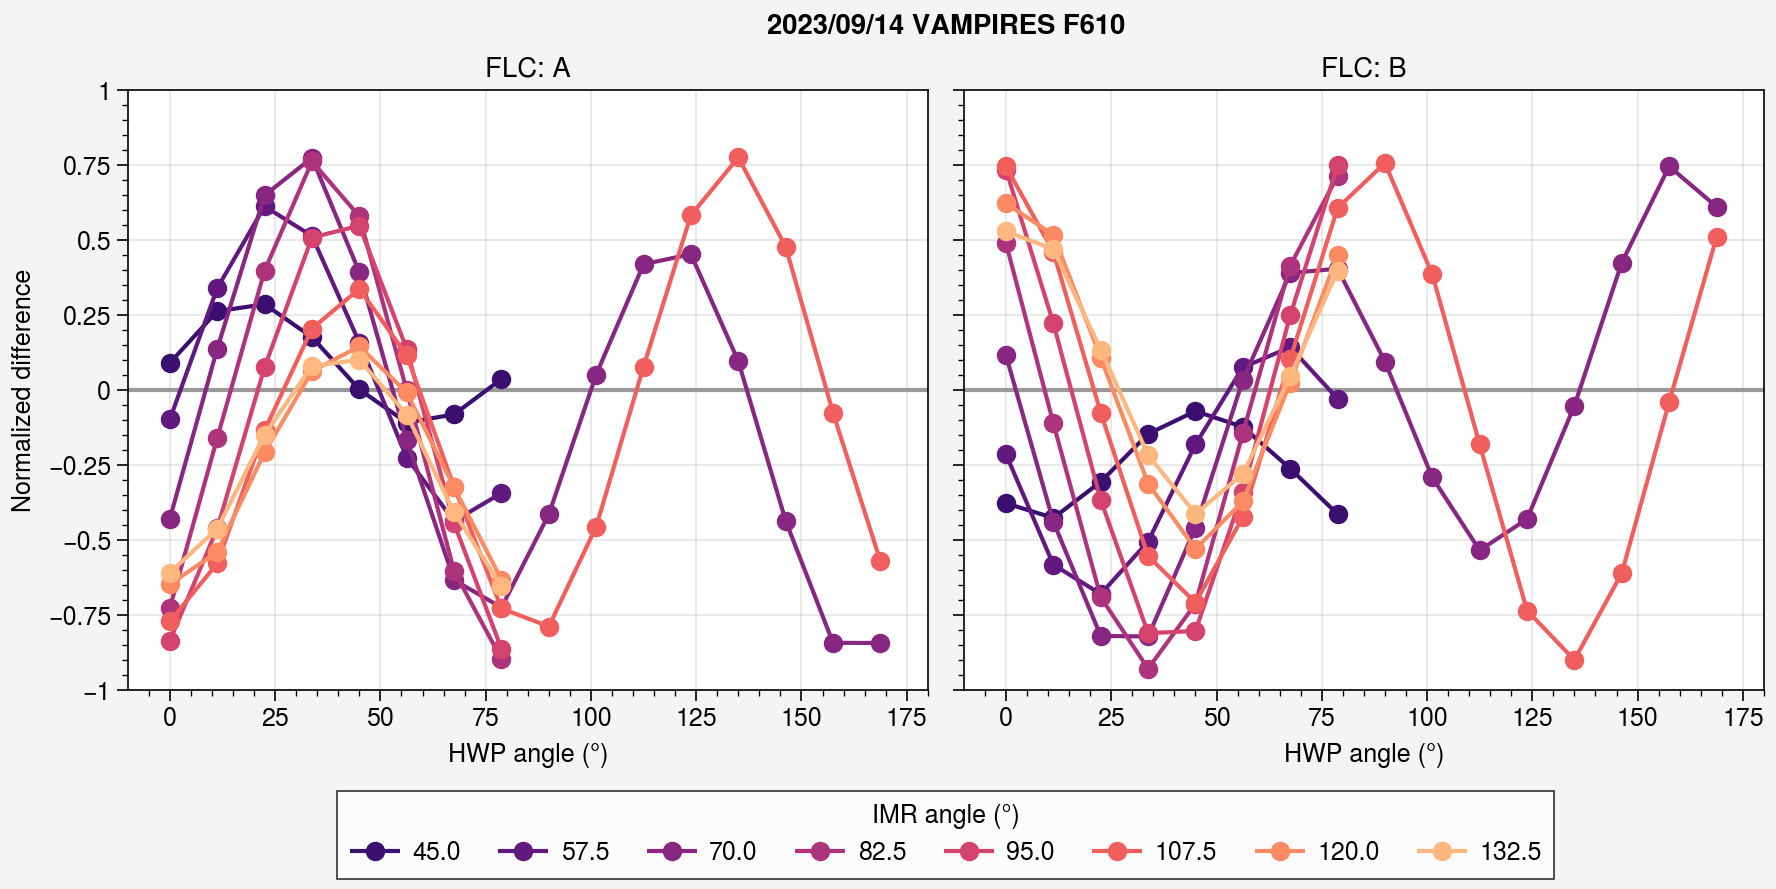

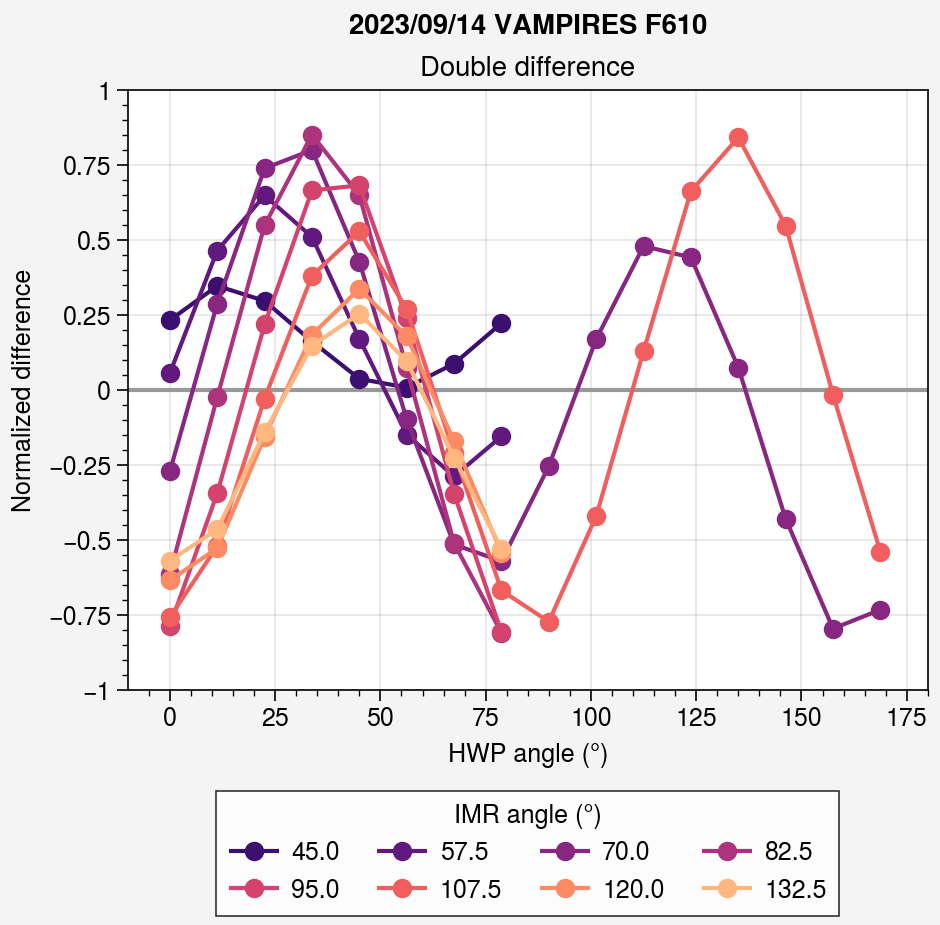

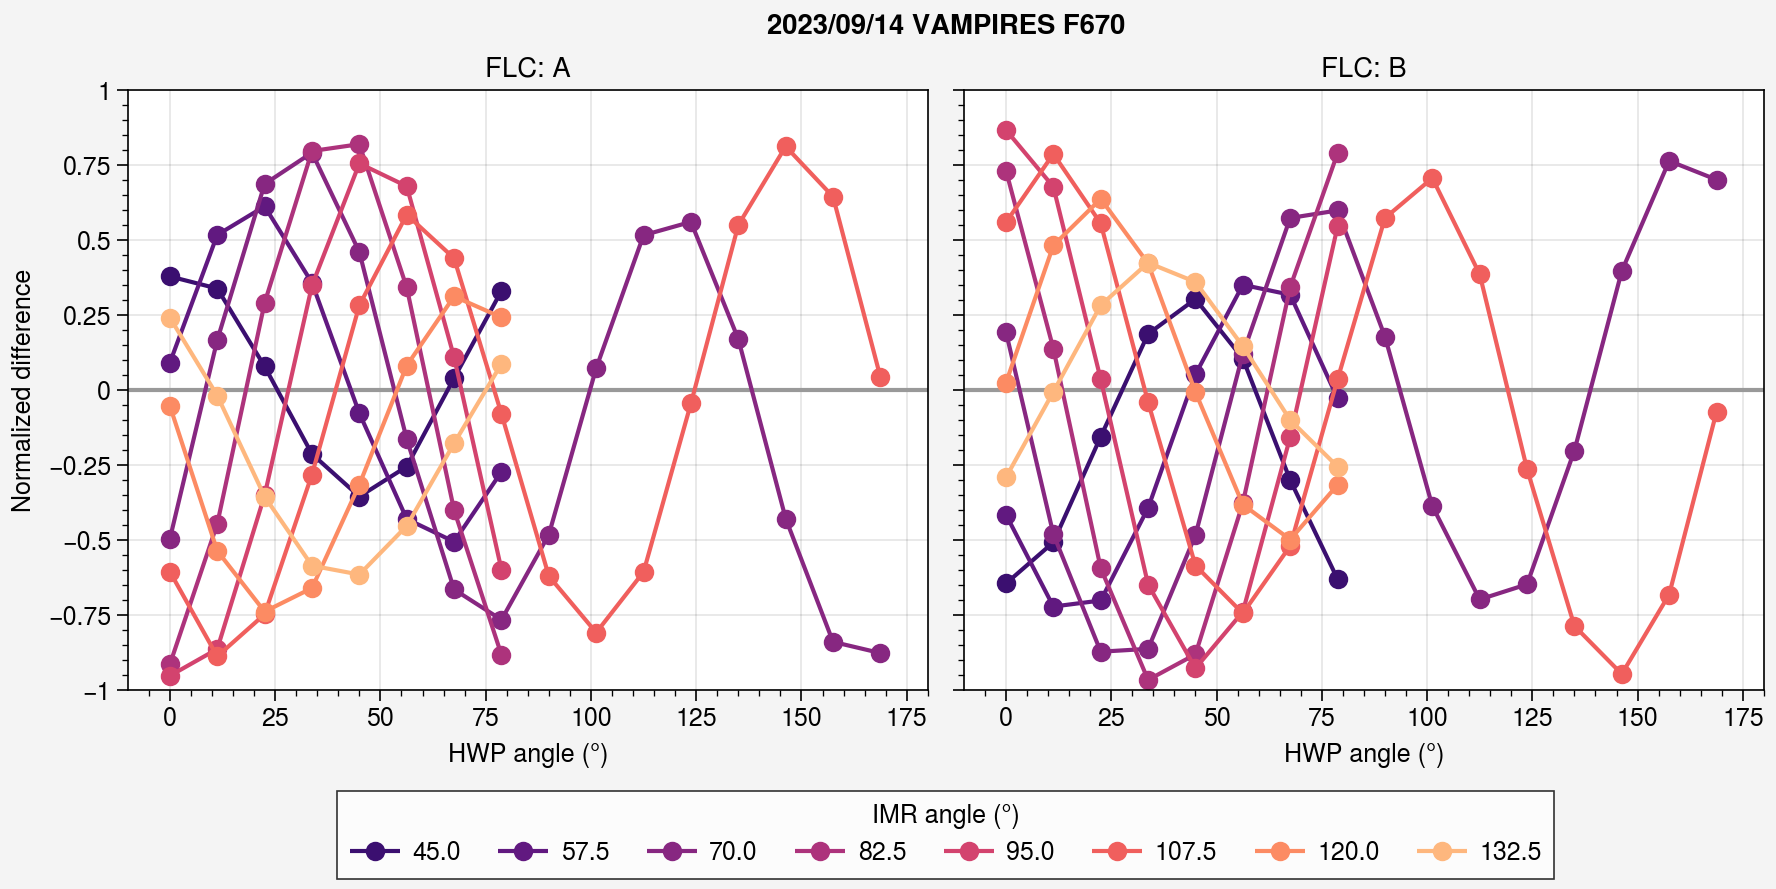

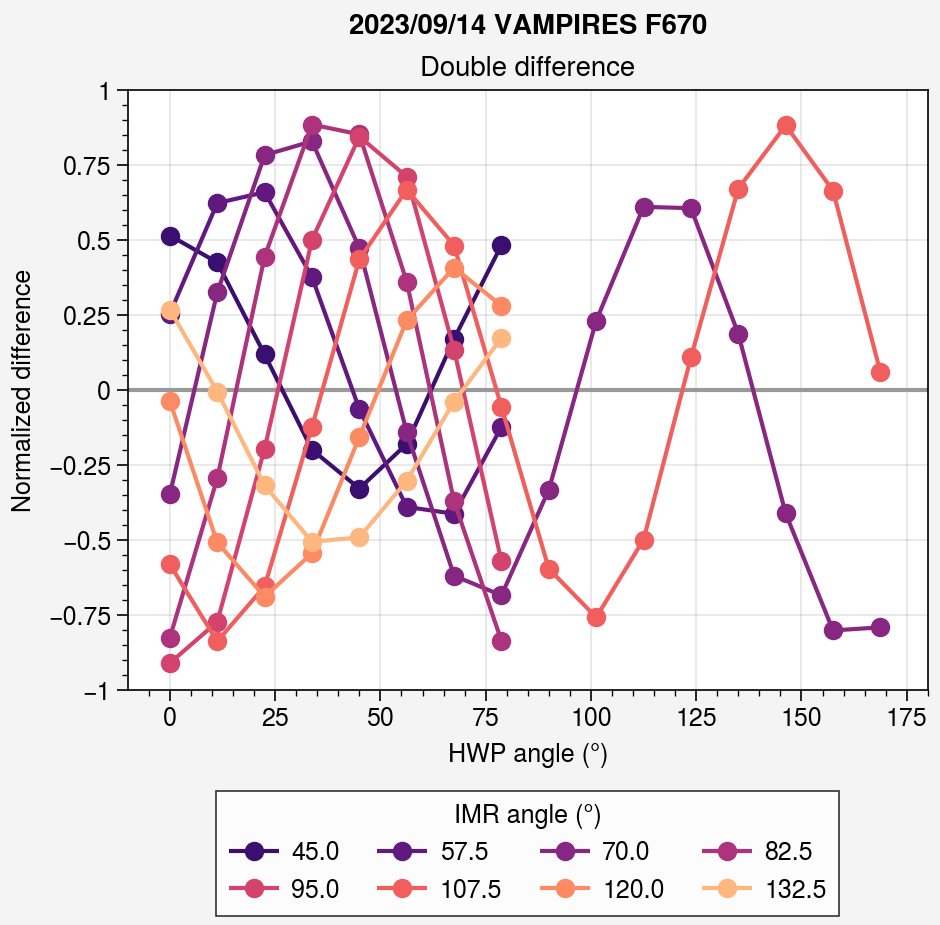

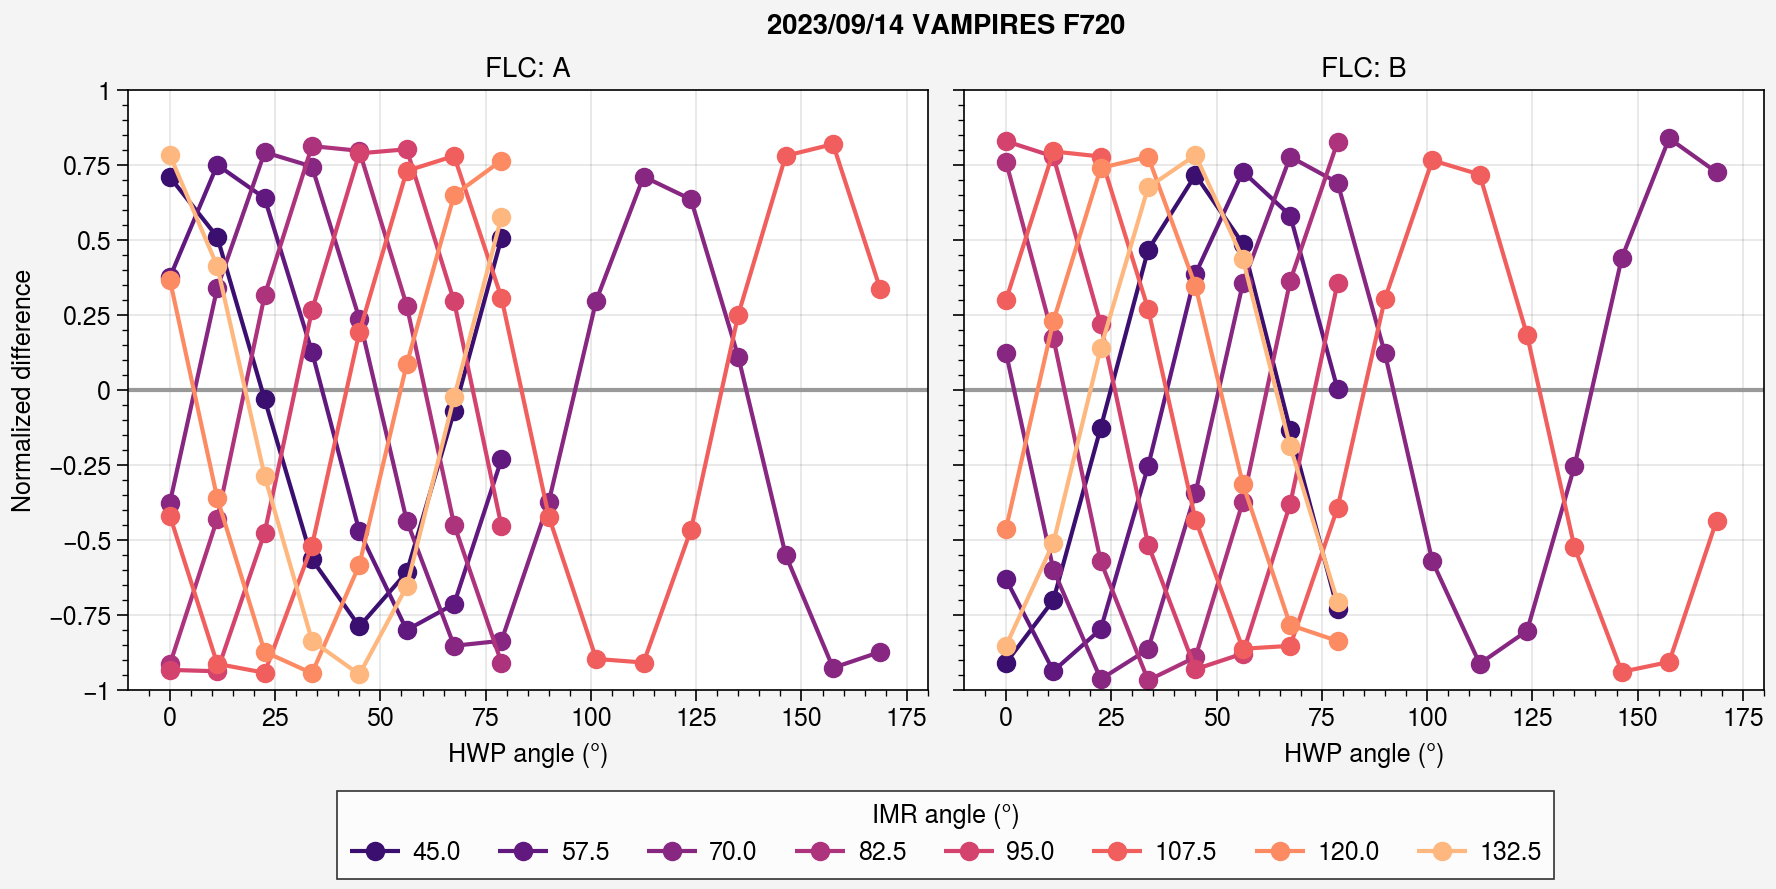

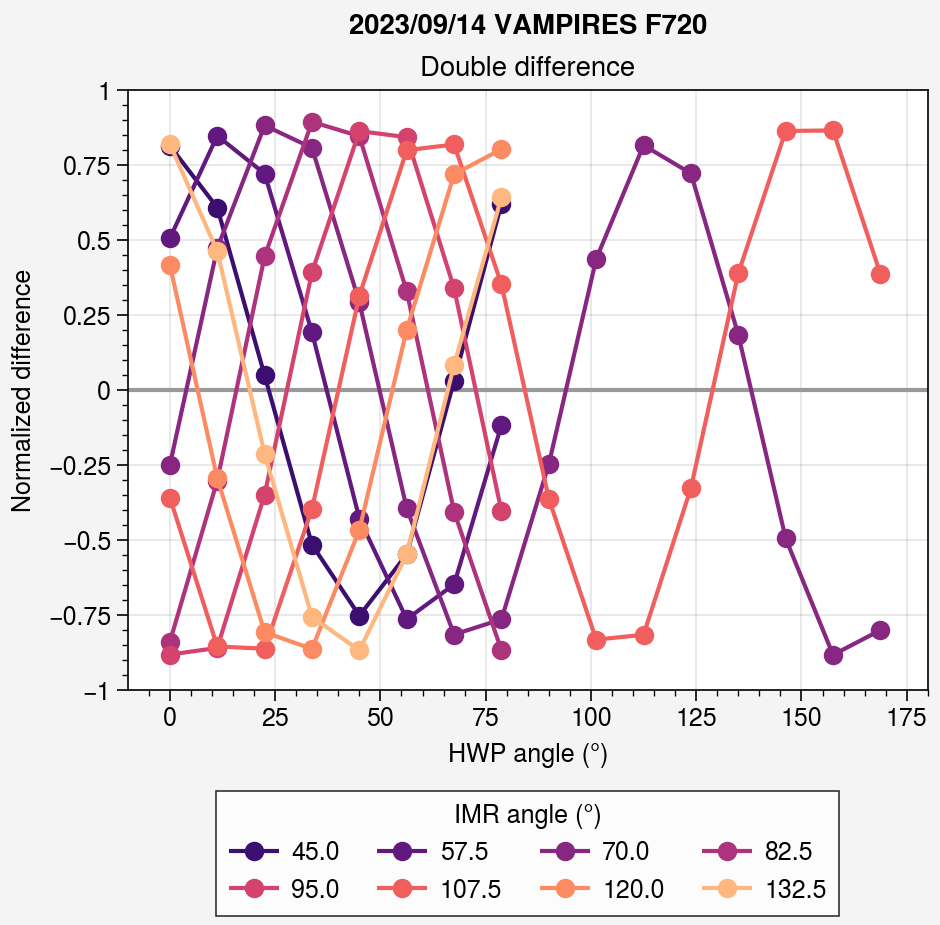

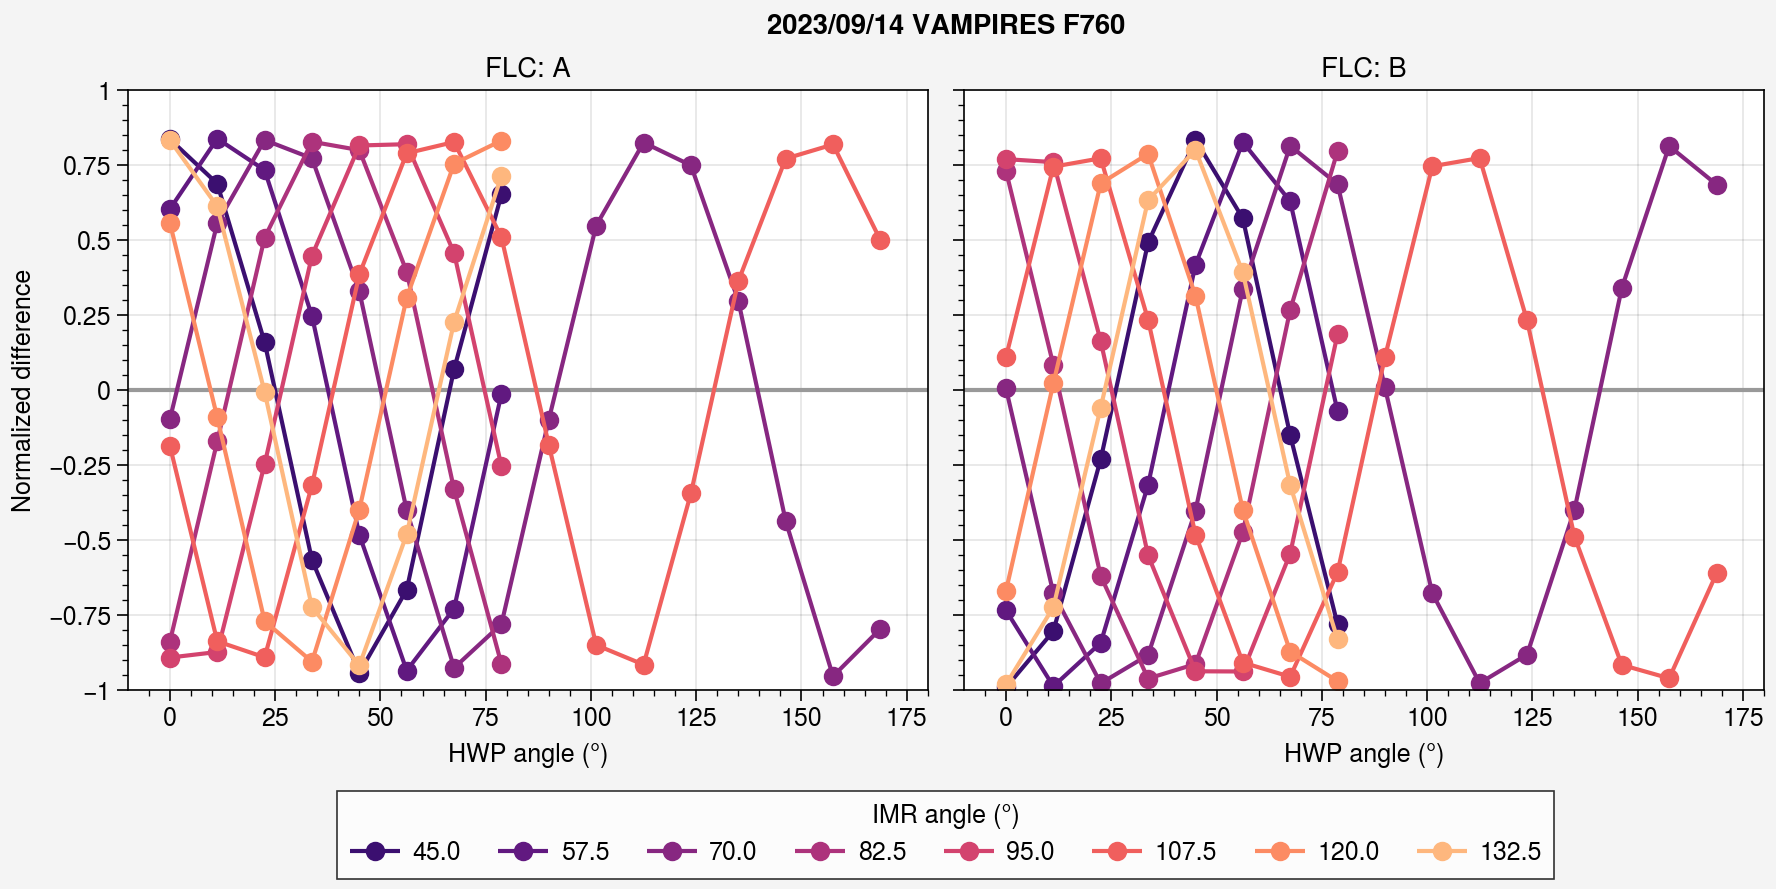

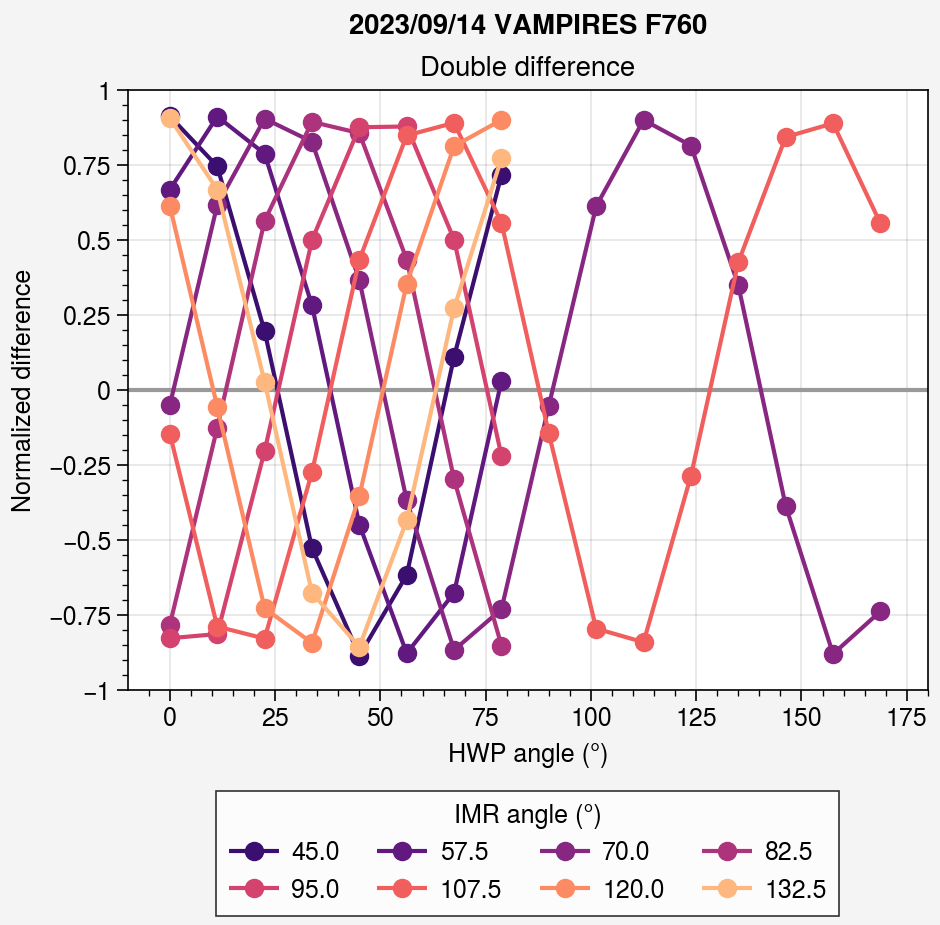

In [97]:
for filt in reversed(mbi_filts):
    plot_single_diff(filt)
    plot_double_diff(filt)

## Standard: 625-50

TypeError: unsupported operand type(s) for /: 'str' and 'str'

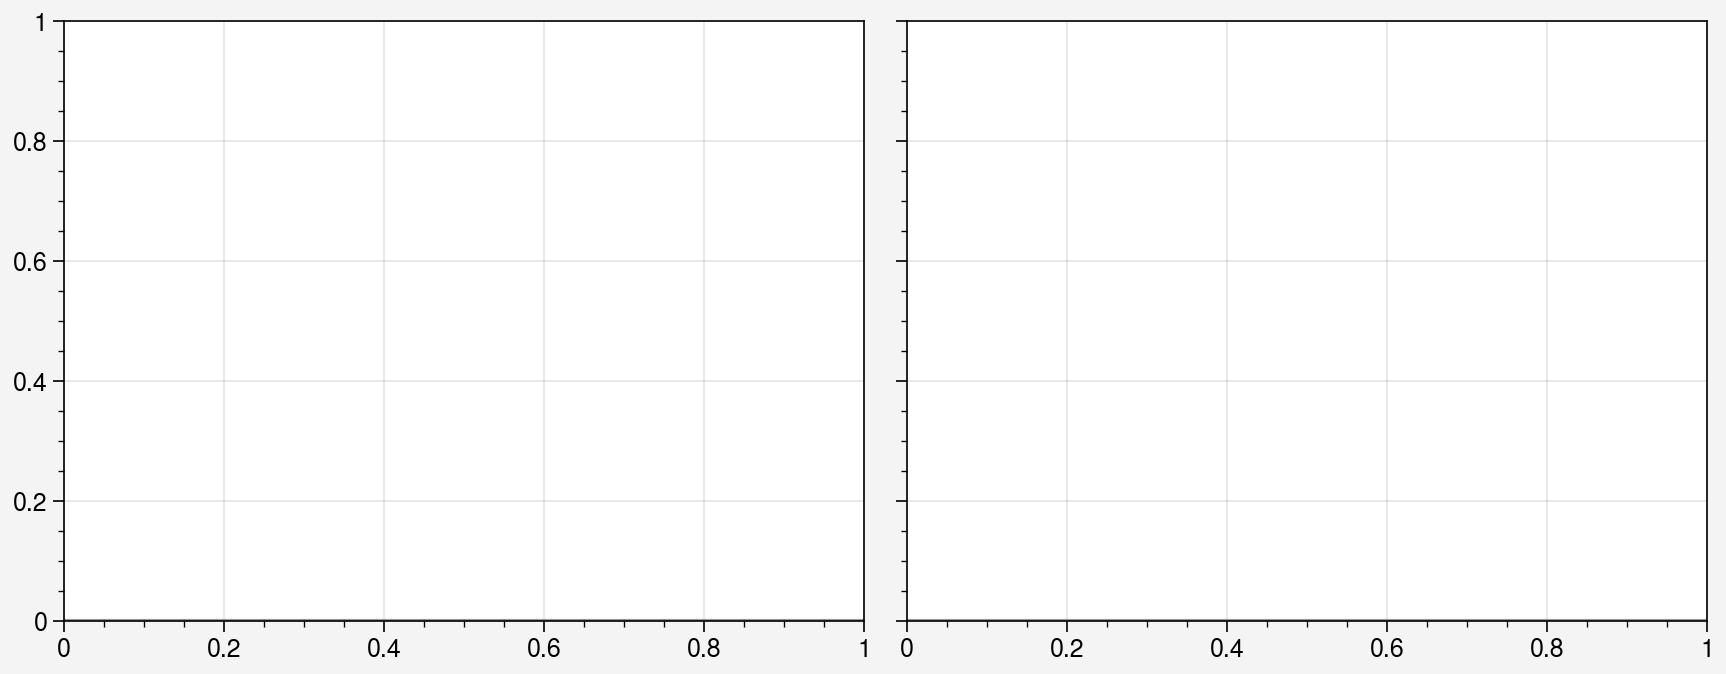

In [98]:
filt = "625-50"
plot_single_diff(filt)
plot_double_diff(filt);

## Standard: 675-50

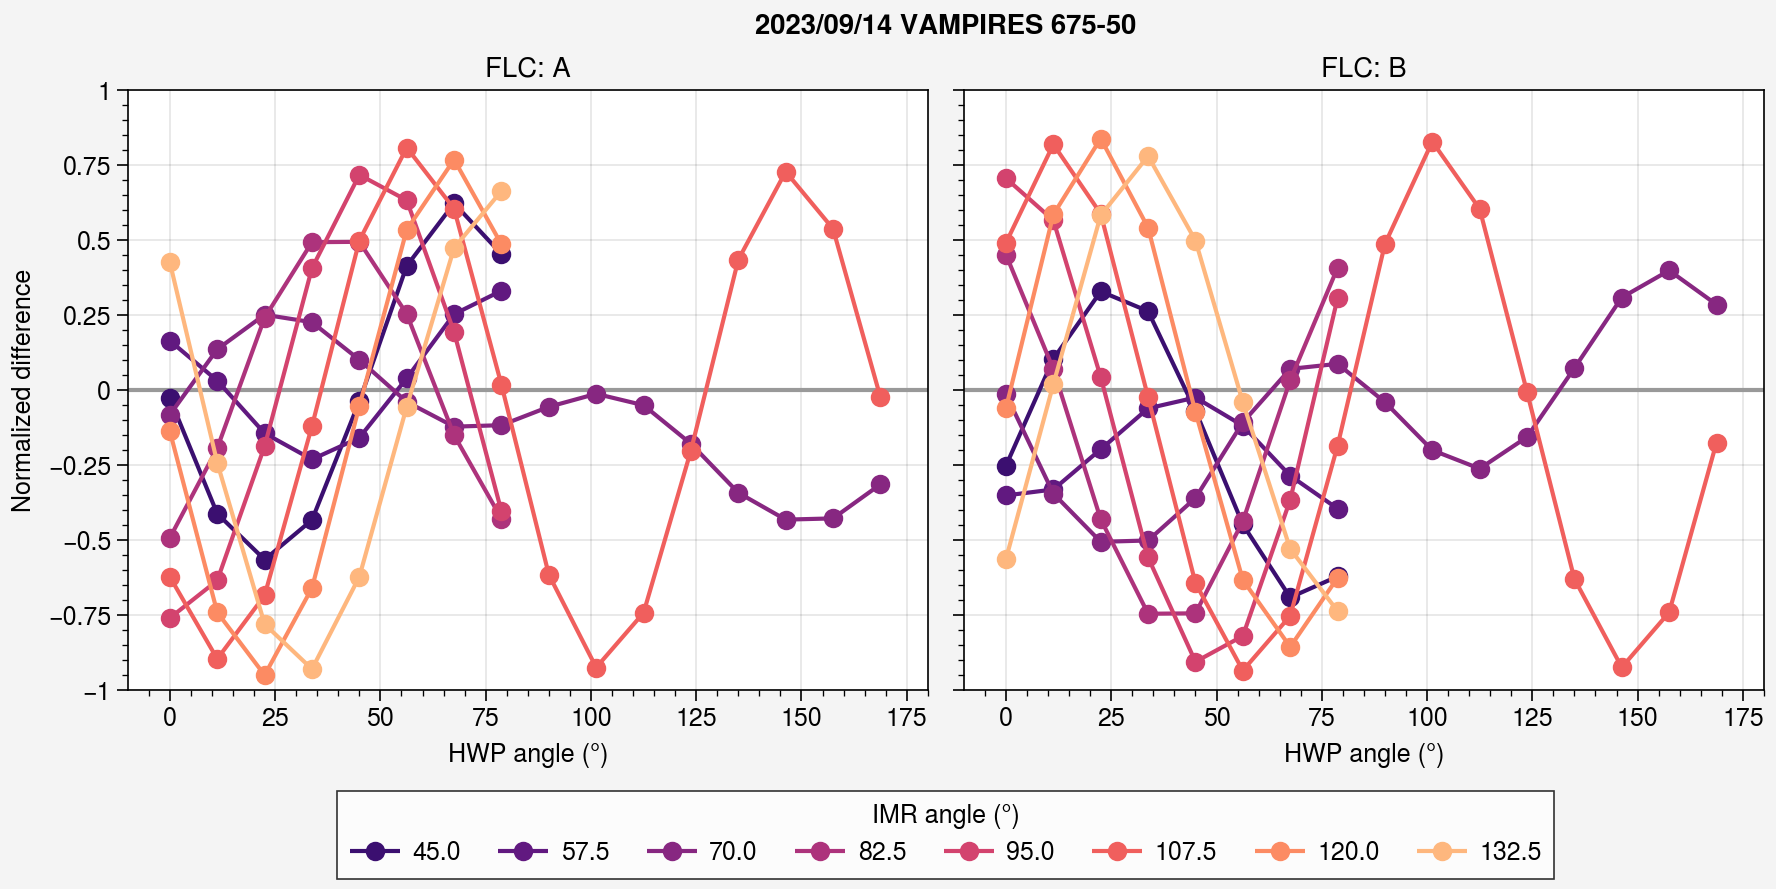

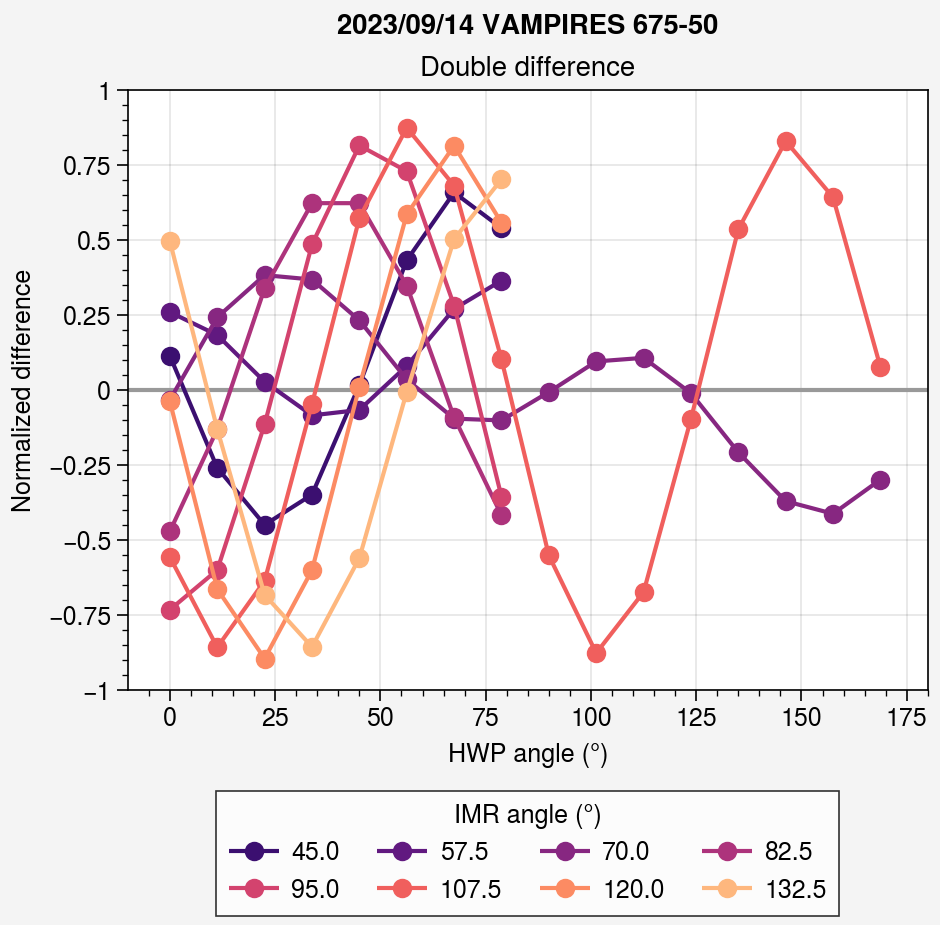

In [179]:
filt = "675-50"
plot_single_diff(filt)
plot_double_diff(filt);

## Standard: 725-50

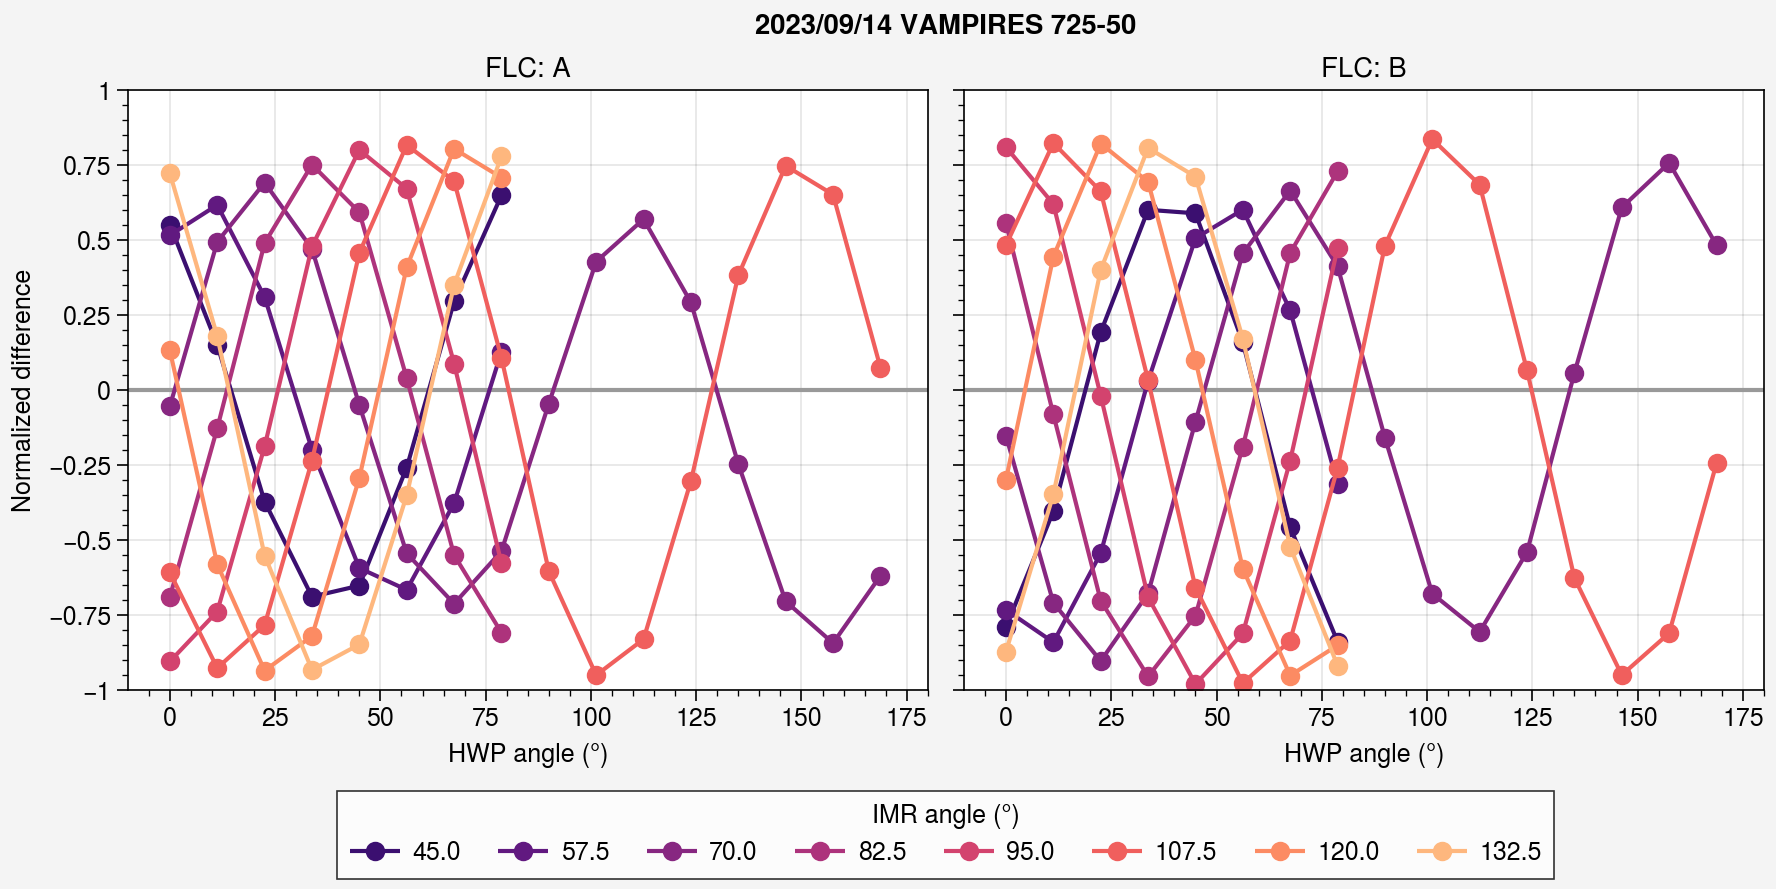

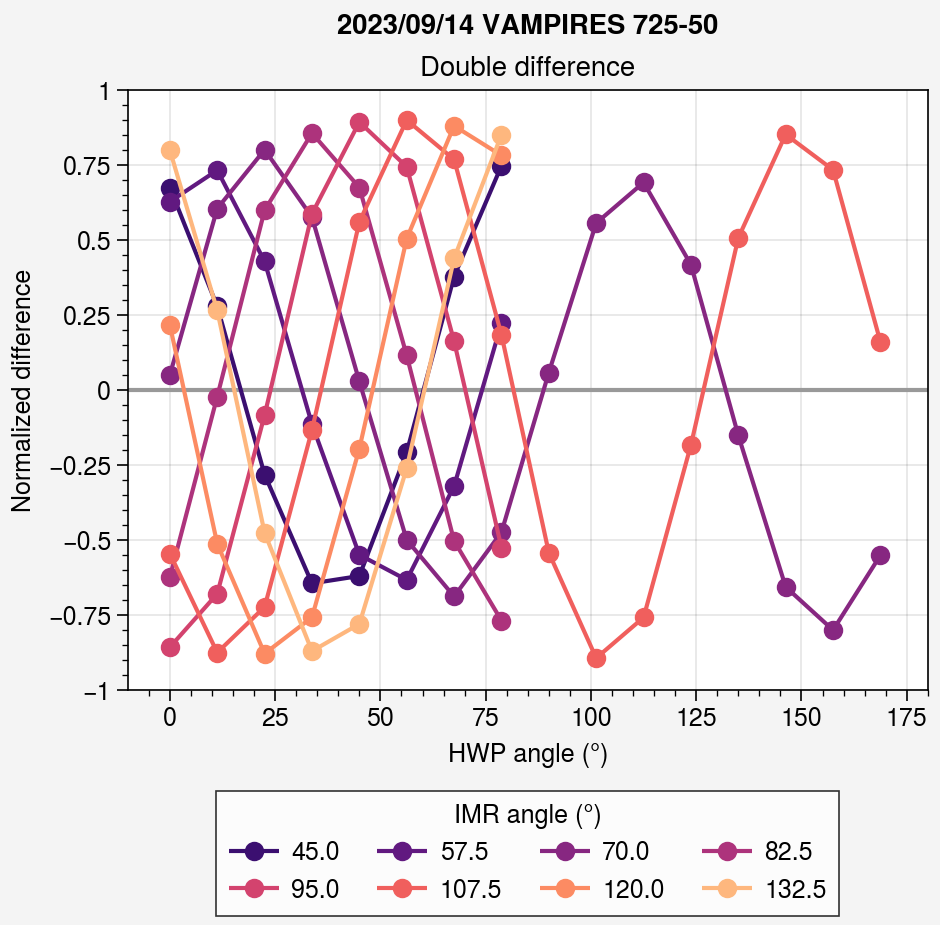

In [188]:
filt = "725-50"
plot_single_diff(filt)
plot_double_diff(filt);

## Standard: 750-50

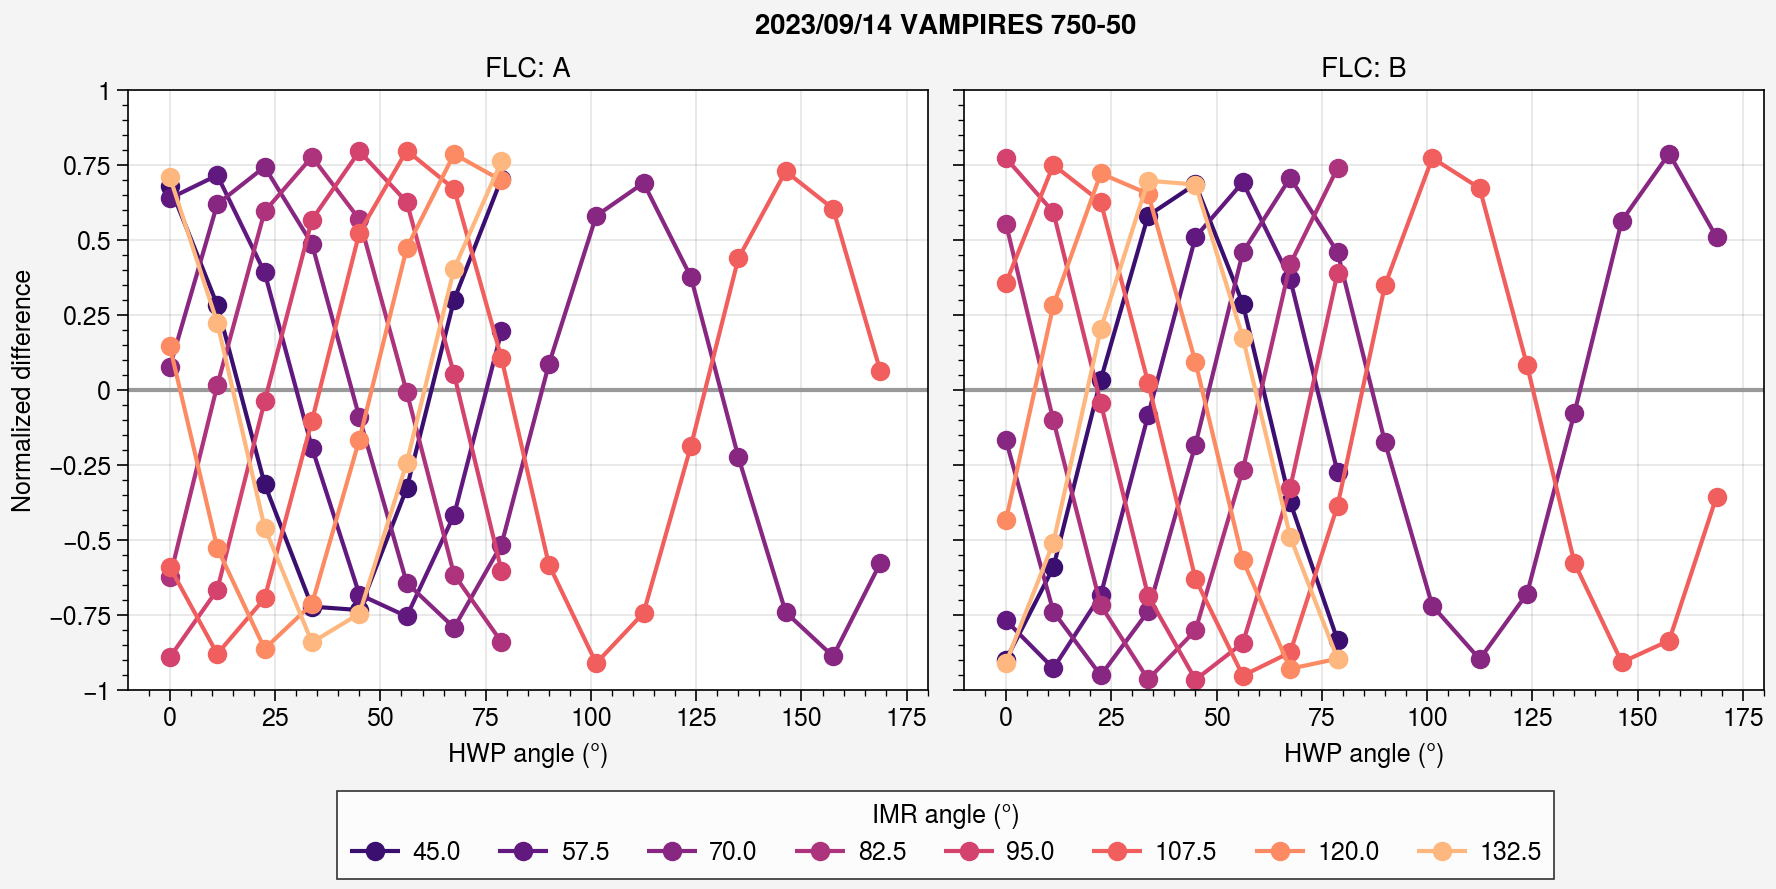

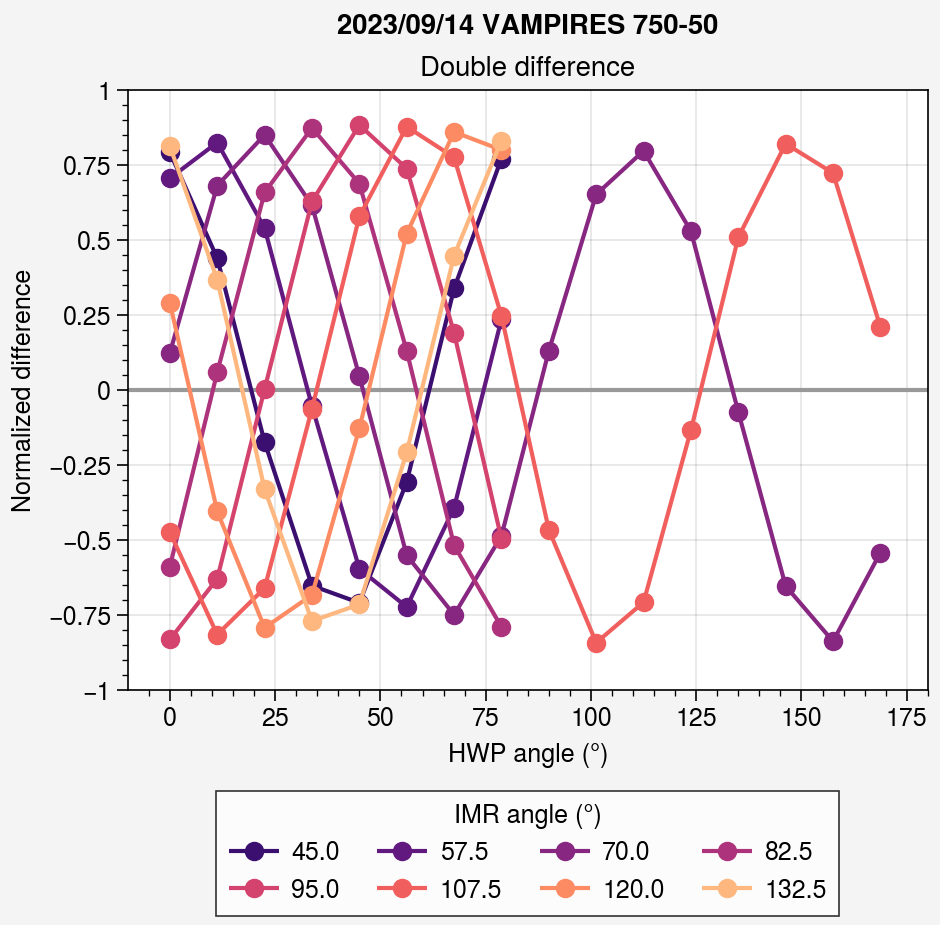

In [181]:
filt = "750-50"
plot_single_diff(filt)
plot_double_diff(filt);

## Standard: 775-50

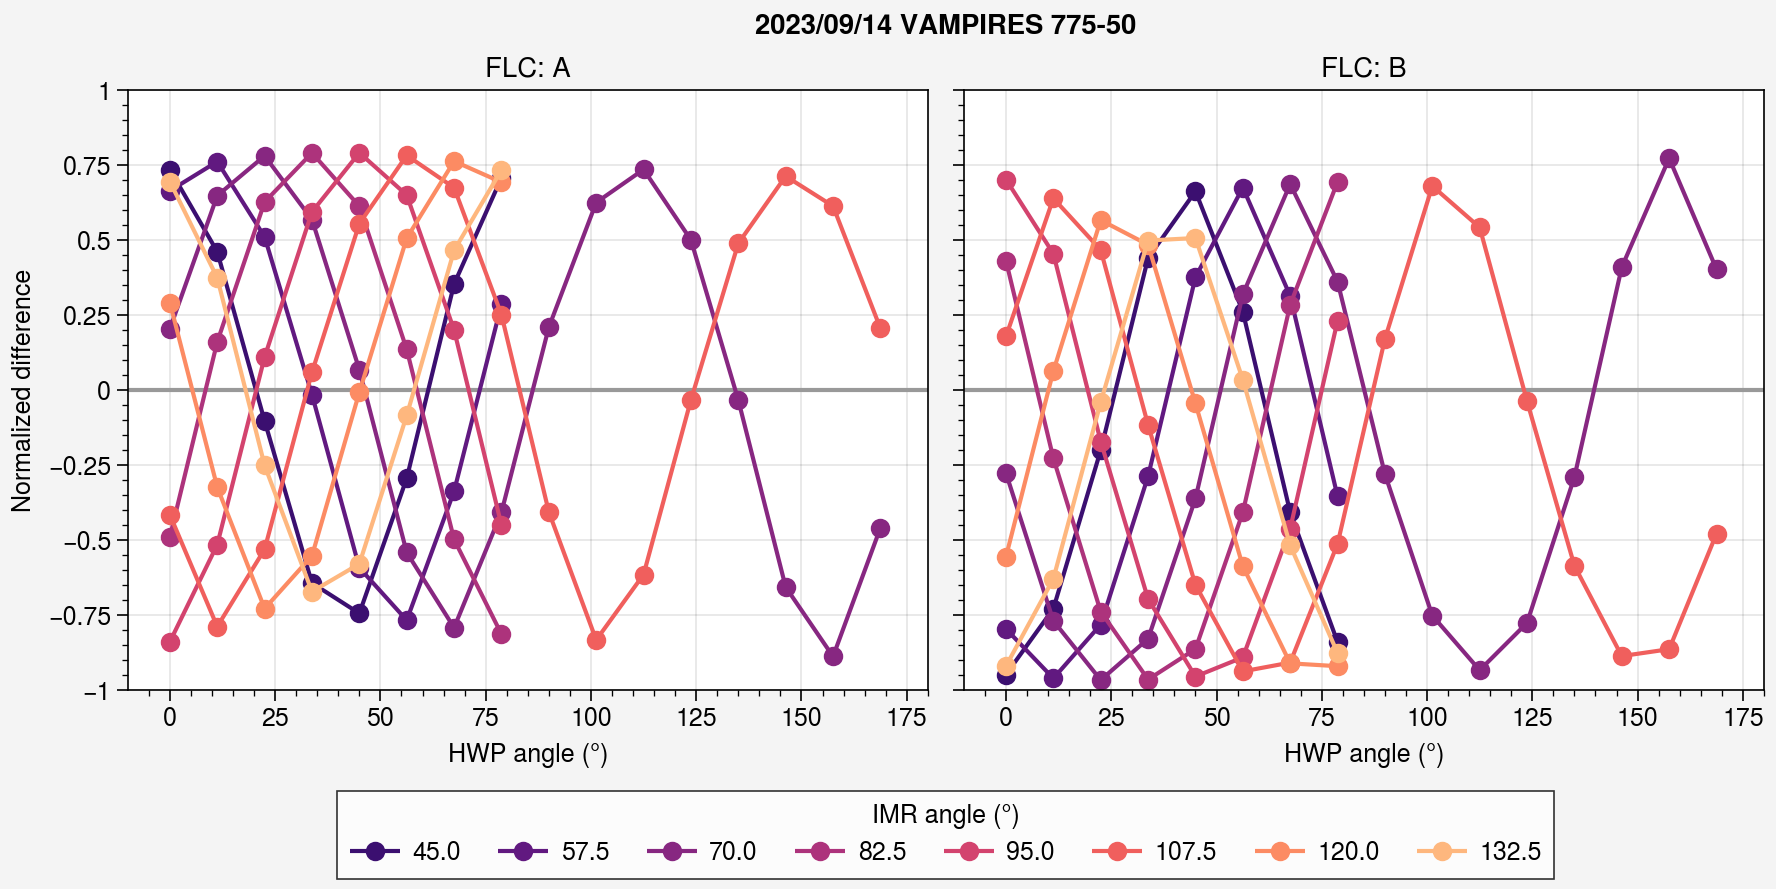

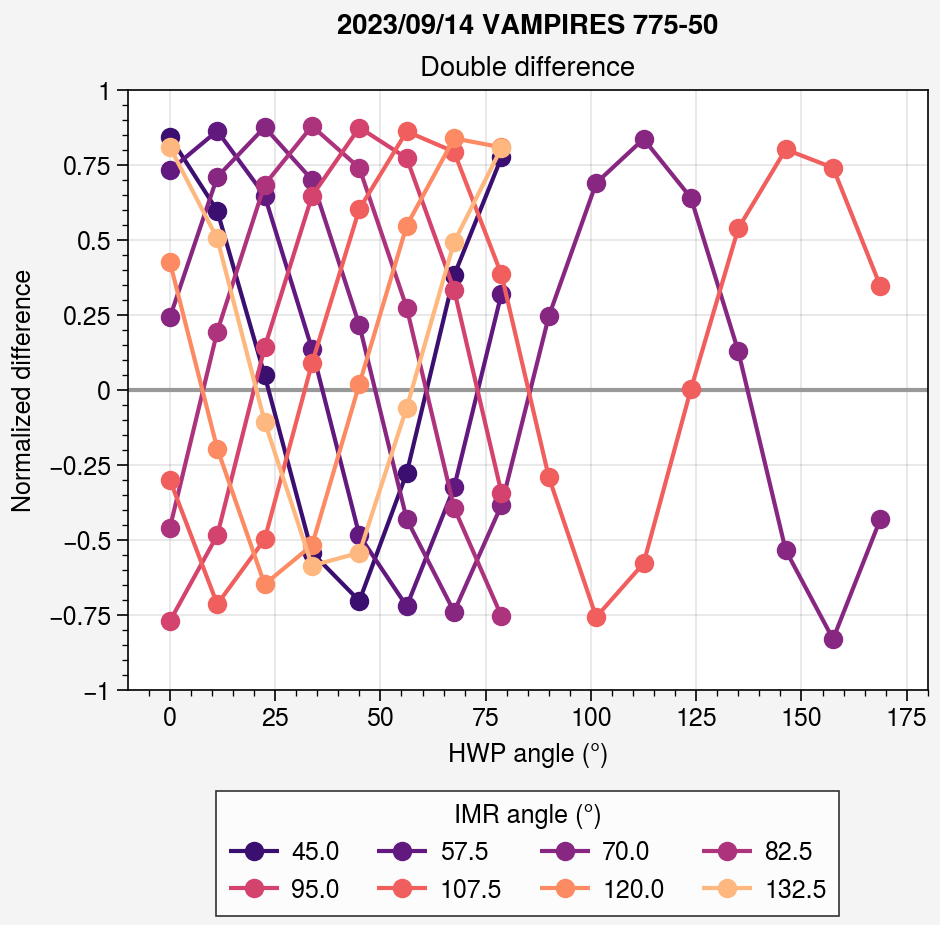

In [182]:
filt = "775-50"
plot_single_diff(filt)
plot_double_diff(filt);

## Standard: Open

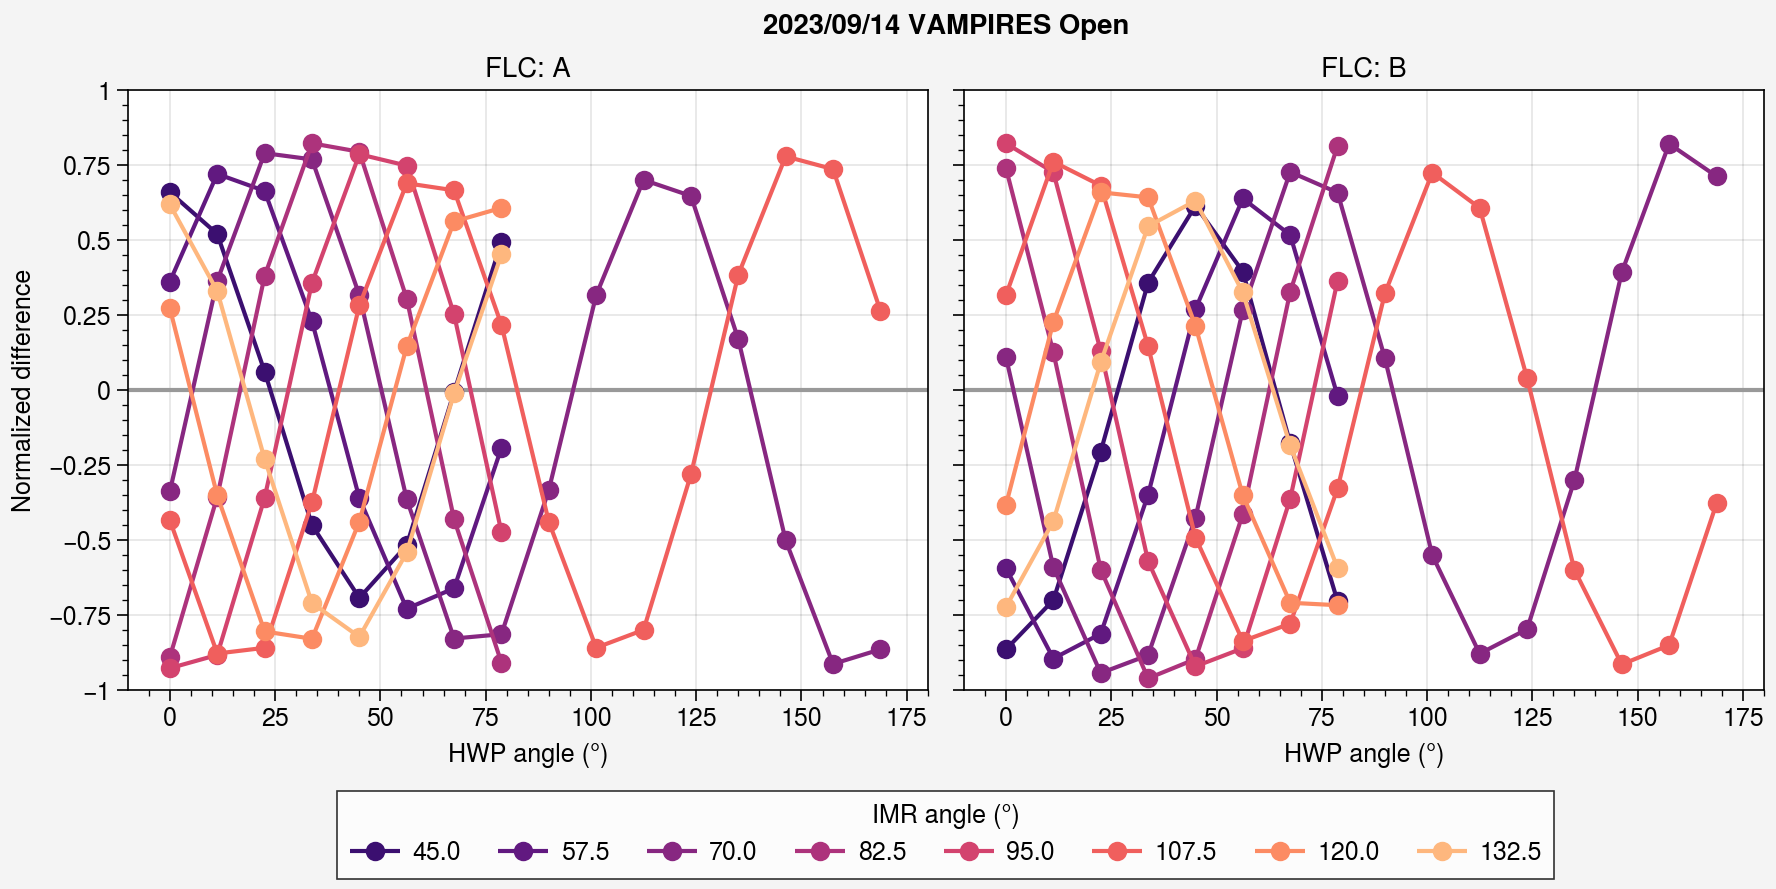

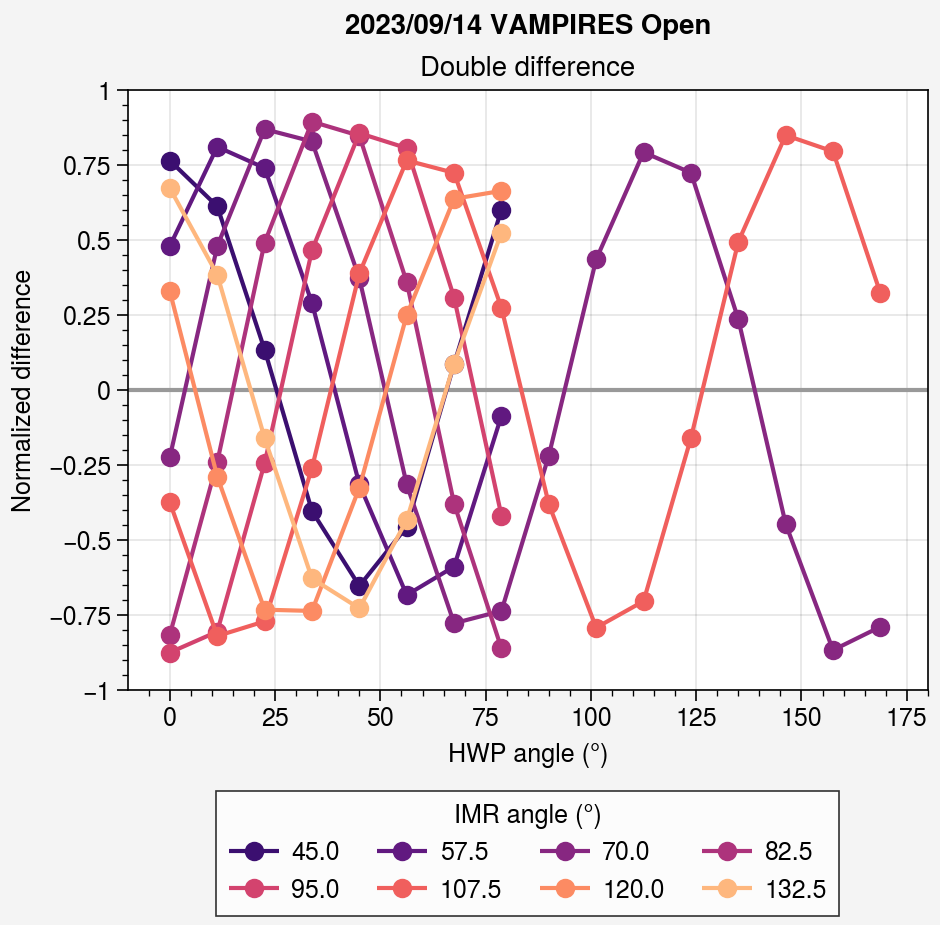

In [183]:
filt = "Open"
plot_single_diff(filt)
plot_double_diff(filt);